# 🧊🌞 Greenland Melting Experiment

### Originally created by Dr. A. Denvil-Sommer (NCAS, Univerity of Reading).

## 🧊 Greenland Melting and Climate Circulation Response

The Greenland ice sheet plays a crucial role in shaping the Northern Hemisphere climate. Its high surface elevation and bright, reflective snow and ice contribute to a strong albedo effect, helping to cool the region and influence large-scale atmospheric circulation.

Removing or reducing Greenland's ice cover — simulating rapid melting — alters both surface elevation and albedo, leading to changes in temperature gradients, jet stream patterns, and storm tracks.

This experiment investigates how the loss of Greenland’s ice sheet affects the climate system, focusing on changes in the Hadley cell, baroclinic activity, and precipitation distribution.

## 🎯 Objective

Explore how **removing Greenland’s ice sheet** - by lowering surface elevation and reducing albedo - affects atmospheric circulation, temperature distribution, and precipitation patterns in a coupled land–ocean simulation using SpeedyWeather.jl.

**📌 Note on Experimental Design**

This experiment is idealised: we simulate the melting of the Greenland ice sheet by reducing orography and surface albedo over Greenland.

⚠️ Importantly, we do not account for freshwater input into the North Atlantic, which would in reality affect ocean circulation (e.g. the AMOC).

This simplification allows us to isolate and investigate the atmospheric response to topographic and radiative changes only.

## 🏔️🧊 Greenland Melting Experiment Setup

We will investigate how Greenland's disappearance—through reduced elevation and surface reflectivity—alters the climate system by comparing two simulations:

**🔹 Control Run (Present-Day Greenland)**
Keep Greenland’s typical high surface elevation and high albedo to represent the current ice-covered state.

**🔸 Perturbed Run (Greenland Melted)**
Lower Greenland’s orography (e.g. flatten it or reduce elevation drastically) and assign a lower surface albedo to mimic exposed bare ground or ocean.

☝️ Use files: 

- `albedo_greenland_exp.nc` with reduced by 50% albedo over Greenland
- `orography_greenland_80%_reduc_exp.nc` with reduced by 80% orography over Greenland


⚠️ Important: Save each simulation to a separate folder or give your output files distinct names to prevent overwriting and simplify comparison later.

## 🧊🔬🧠 Guiding Questions 

- How does the surface temperature change after lowering Greenland’s orography and albedo?

- Do the poleward temperature gradients or temperature asymmetries between hemispheres change?

- Is there a shift in the location or intensity of storm tracks in the North Atlantic?

- How do zonal winds or jet stream structure respond to the altered topography and surface reflectivity?

- Do precipitation patterns over the North Atlantic and Arctic change significantly?

- Can you detect a change in the Hadley or Ferrel cells due to altered heat fluxes?

- How might these changes relate to known feedback mechanisms in Earth’s climate (e.g., ice-albedo feedback, baroclinic adjustment)?

- Can this be considered a climate tipping point scenario in simplified modeling?

## 💾 Variables to Investigate — Greenland Melting Experiment

To assess how removing Greenland’s ice sheet impacts the climate system:

**🌡️ Temperature & Surface Conditions**
- 🌍 Surface Air Temperature
`simulation.diagnostic_variables.grid.temp_grid[:, end]`

- 🌊 Sea Surface Temperature (SST) (to check oceanic impact)
`simulation.prognostic_variables.ocean.sea_surface_temperature`

- 🌫️ Near-Surface Specific Humidity
`simulation.diagnostic_variables.grid.humid_grid`

**🌬️ Atmospheric Circulation**
- 🌬️ Surface Winds (Zonal & Meridional)
`simulation.diagnostic_variables.grid.u_grid`
`simulation.diagnostic_variables.grid.v_grid`

- 🌀 Relative Vorticity
`simulation.diagnostic_variables.spectral.vort`

- 📉 Pressure Tendency (for Hadley/Ferrel cell diagnostics)
`simulation.diagnostic_variables.tendencies.pres_tend`

**🌧️ Hydrological Cycle**
- 🌧️ Total Precipitation (Large-scale & Convective)

`simulation.diagnostic_variables.physics.precip_large_scale`

`simulation.diagnostic_variables.physics.precip_convective`

**☀️ Surface Forcing**

- ☀️ Net Shortwave Radiation at Surface shows how surface energy absorption changed due to albedo.

In [1]:
using SpeedyWeather
using Dates
using CairoMakie

In [2]:
# 1. Define the grid and components
spectral_grid = SpectralGrid(trunc=21, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, id="Climate_Ocean_Greenland", output_dt=Minute(180))
add!(output, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput())  # output also temperature and precip

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 10800 seconds
└┐ variables:
 ├ precip_conv: accumulated convective precipitation [mm]
 ├ v: meridional wind [m/s]
 ├ humid: specific humidity [kg/kg]
 ├ temp: temperature [degC]
 ├ u: zonal wind [m/s]
 ├ pres: surface pressure [hPa]
 ├ precip_cond: accumulated large-scale precipitation [mm]
 └ vor: relative vorticity [s^-1]

In [3]:
# 2. Create land and ocean models
vertical_advection = WENOVerticalAdvection(spectral_grid)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
temperature=LandBucketTemperature(spectral_grid)
soil_moisture=LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
ocean = SlabOcean(spectral_grid, mixed_layer_depth=50)

SlabOcean{Float32} <: AbstractOcean
├ temp_equator::Float32 = 302.0
├ temp_poles::Float32 = 273.0
├ specific_heat_capacity::Float32 = 4184.0
├ mixed_layer_depth::Float32 = 50.0
├ density::Float32 = 1000.0
├ mask::Bool = false
└ heat_capacity_mixed_layer::Float32 = 2.092e8

In [4]:
# 3. Set up albedo component
albedo = Albedo(GlobalConstantAlbedo(spectral_grid, albedo=0.06), AlbedoClimatology(spectral_grid,path="/Users/annasommer/Documents/Documents - J73343QGPF/HRCM/CMSS2025/Practical_Sessions",file="albedo_greenland_exp.nc"))

Albedo <: SpeedyWeather.AbstractAlbedo
├ ocean: GlobalConstantAlbedo{Float32}
└ land: AlbedoClimatology{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}

In [5]:
orography = EarthOrography(spectral_grid, 
                                path="/Users/annasommer/Documents/Documents - J73343QGPF/HRCM/CMSS2025/Practical_Sessions",
                                file="orography_greenland_80%_reduc_exp.nc",
                                file_Grid=FullClenshawGrid)

EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}, LowerTriangularMatrix{ComplexF32, Vector{ComplexF32}, Spectrum{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}} <: SpeedyWeather.AbstractOrography
├ path::String = /Users/annasommer/Documents/Documents - J73343QGPF/HRCM/CMSS2025/Practical_Sessions
├ file::String = orography_greenland_80%_reduc_exp.nc
├ file_Grid::UnionAll = FullClenshawGrid
├ scale::Float32 = 1.0
├ smoothing::Bool = true
├ smoothing_power::Float32 = 1.0
├ smoothing_strength::Float32 = 0.1
├ smoothing_fraction::Float32 = 0.05
└── arrays: orography, geopot_surf

In [6]:
# create model, initialize, run
time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(40)) #CPL this is the standar time step

### Entirely new run
model = PrimitiveWetModel(spectral_grid; vertical_advection, time_stepping, large_scale_condensation, convection, land, ocean, albedo, orography, output=output)

add!(model, SpeedyWeather.AllOutputVariables()...)
simulation = initialize!(model)

Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

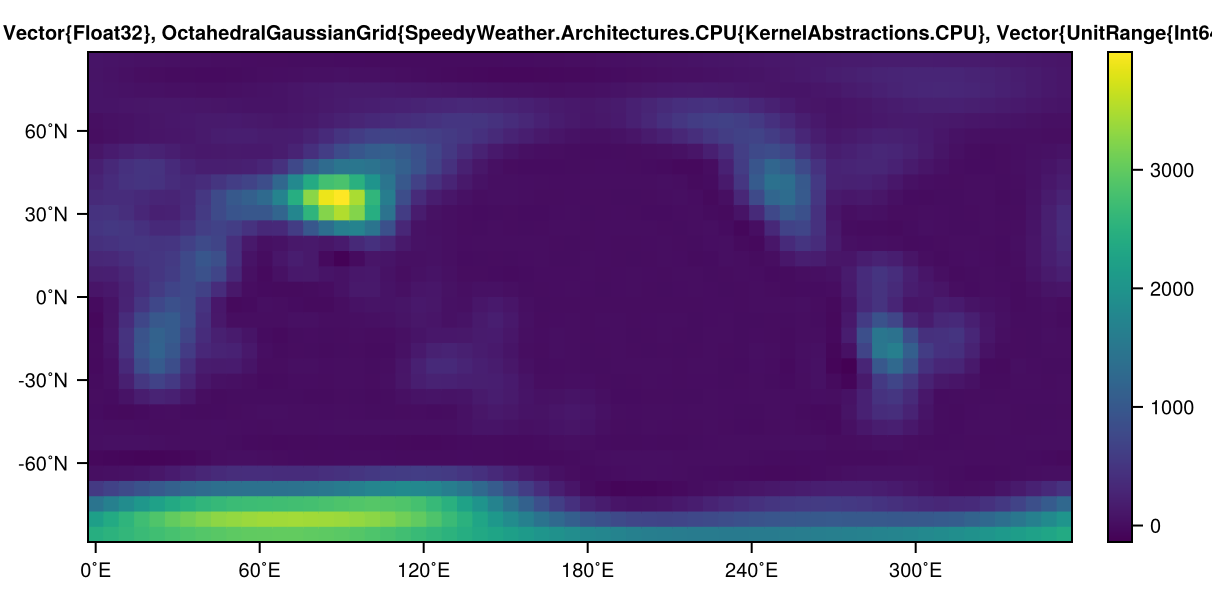

In [7]:
heatmap(orography.orography)

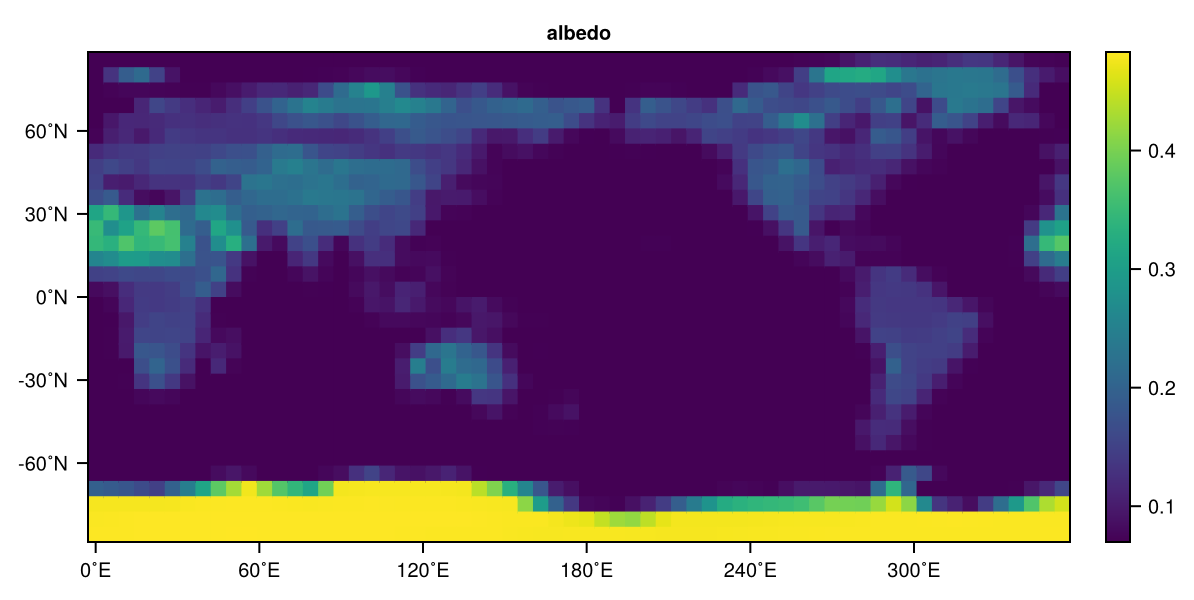

In [8]:
# visualise intial land albedo
alb = simulation.model.albedo.land.albedo
heatmap(alb, title="albedo")

In [10]:
# visualise intial ocean albedo
alb = simulation.model.albedo.ocean.albedo
#heatmap(alb, title="albedo")
alb

0.06f0

In [11]:
# run the simualtion
run!(simulation, period=Day(30*365), output=true)

Weather is speedy: run_Climate_Ocean_Greenland_0002 100% Time: 1:54:10 (378.35 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

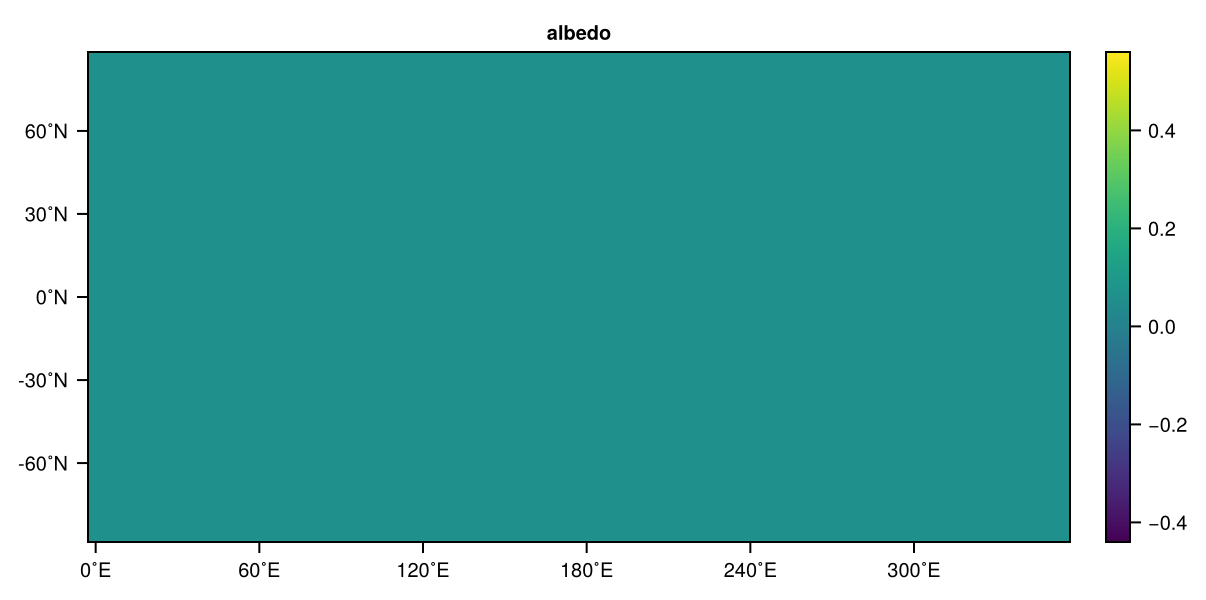

In [12]:
alb = simulation.diagnostic_variables.physics.ocean.albedo
heatmap(alb, title="albedo")

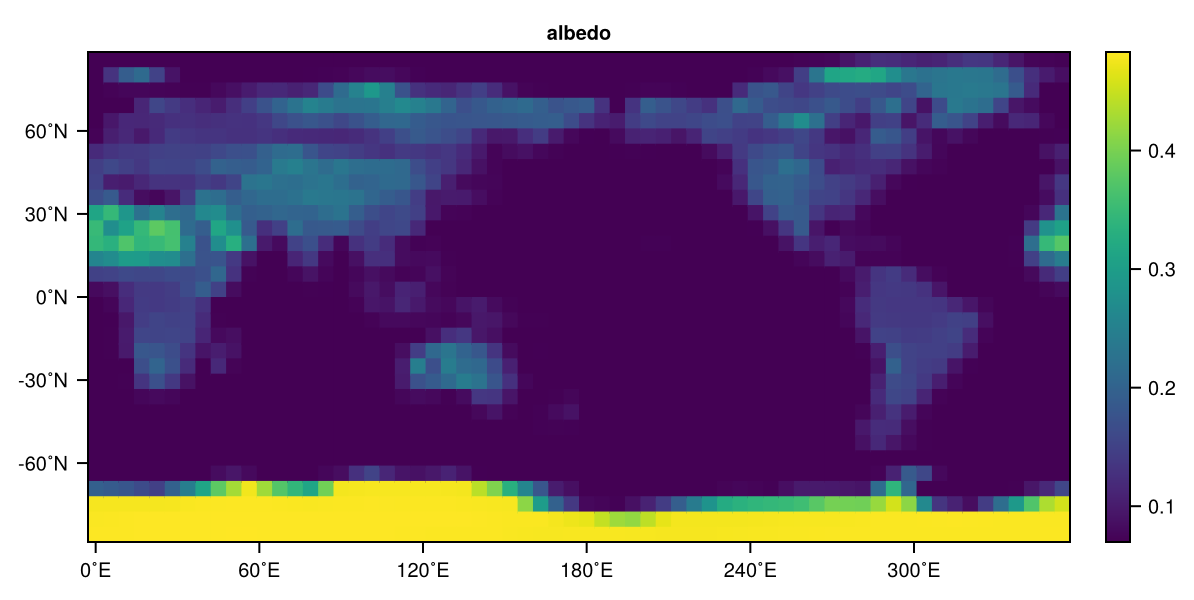

In [13]:
alb_land = simulation.diagnostic_variables.physics.land.albedo
heatmap(alb_land, title="albedo")

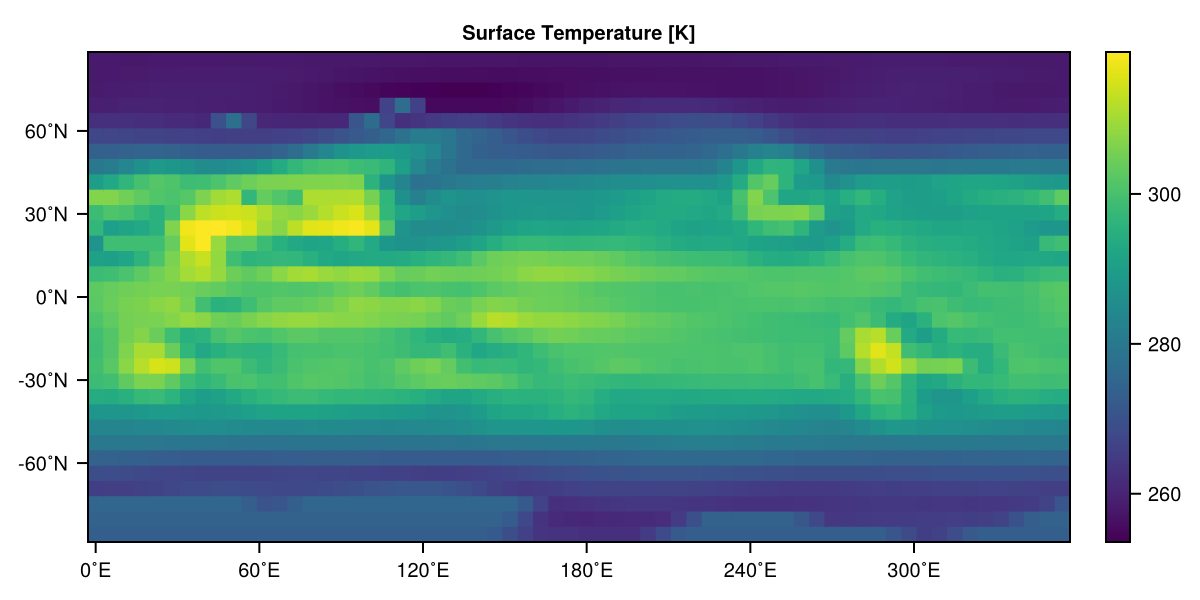

In [14]:
sst = simulation.prognostic_variables.ocean.sea_surface_temperature
heatmap(sst, title="Surface Temperature [K]")

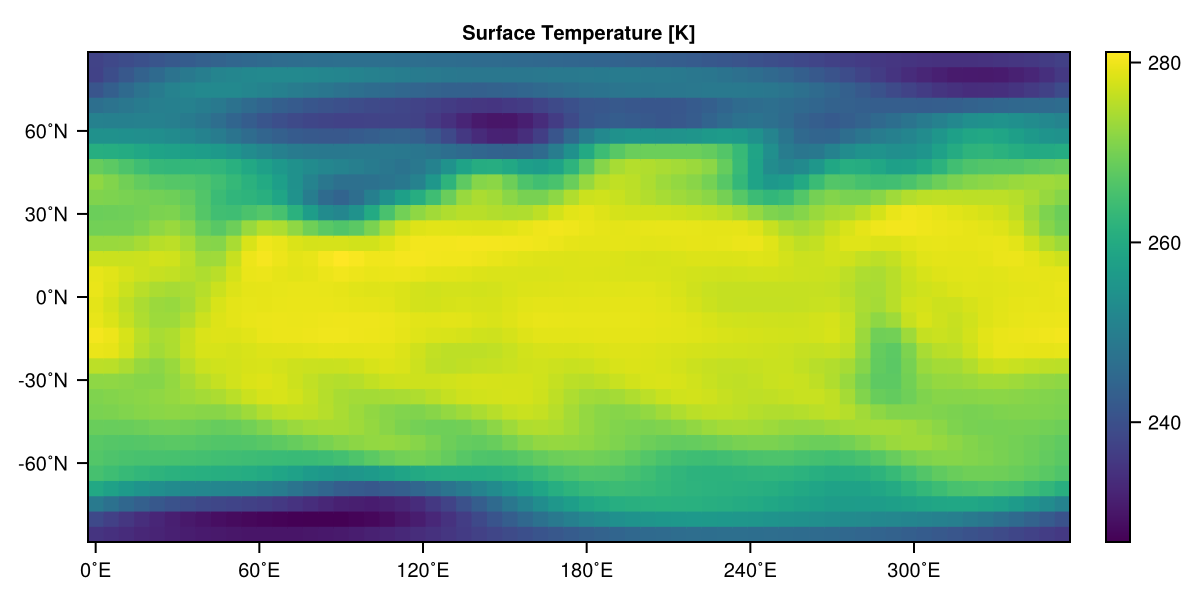

In [15]:
T = simulation.diagnostic_variables.grid.temp_grid[:, 8]
heatmap(T, title="Surface Temperature [K]")

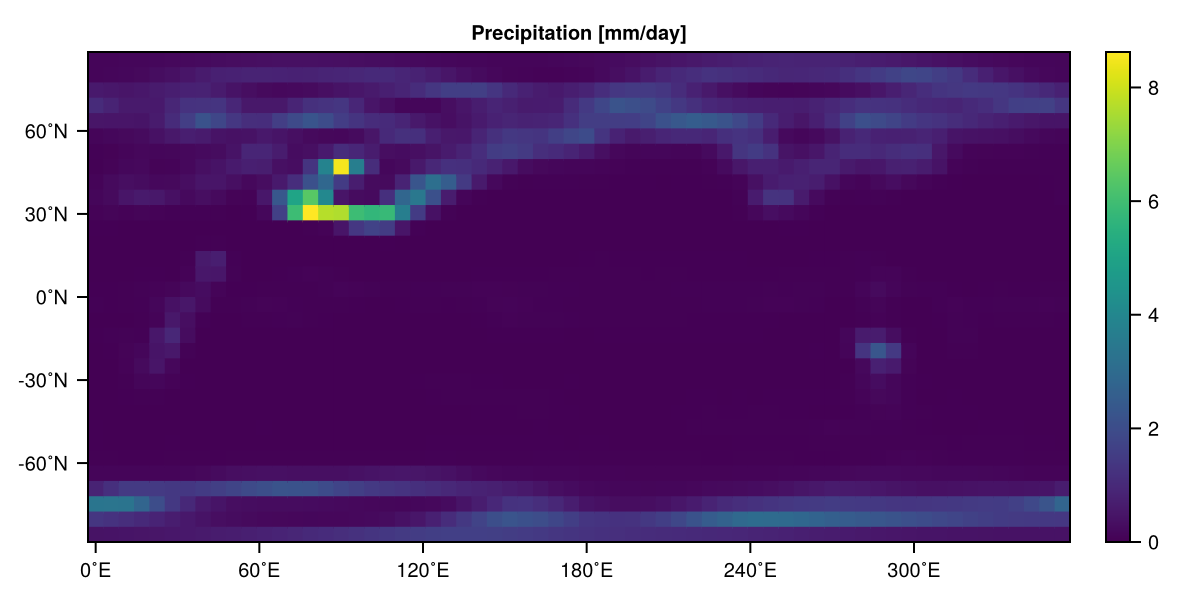

In [16]:
P = simulation.diagnostic_variables.physics.precip_large_scale
heatmap(P, title="Precipitation [mm/day]")

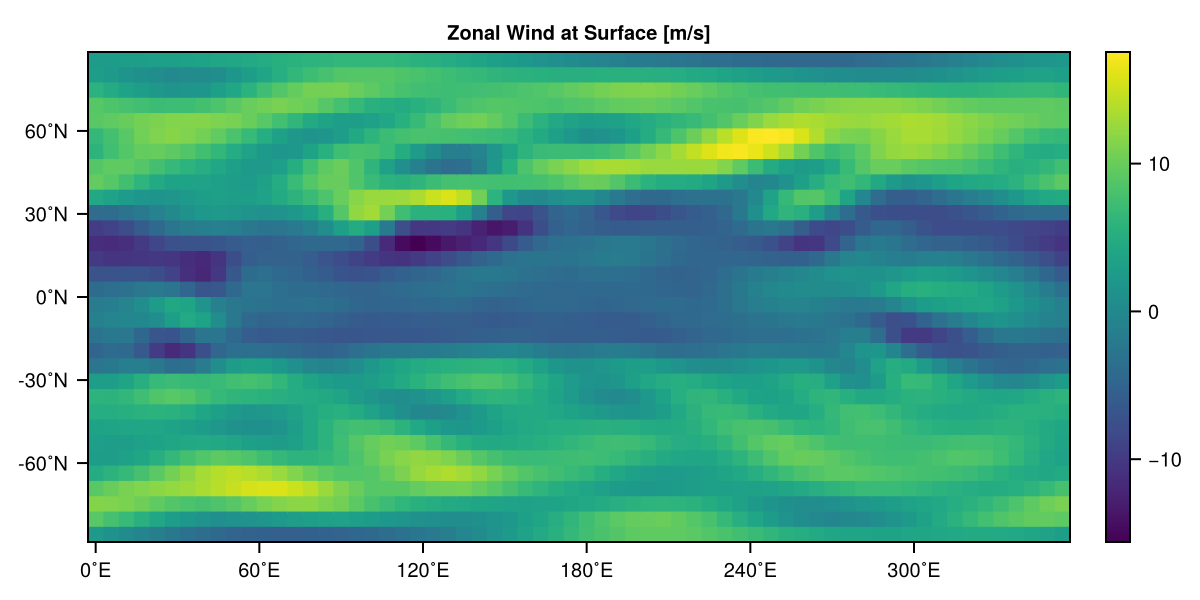

In [17]:
U = simulation.diagnostic_variables.grid.u_grid[:, 8]
heatmap(U, title="Zonal Wind at Surface [m/s]")